## Group Project Title: Anlysis of Blue Voters in Red States

Group Members: Joseph Chang, Grant Cai, Chen Guo

In [1]:
from pyspark.sql import SparkSession
import pyspark as ps
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pyspark.sql.functions as f
import pandas as pd
from pyspark.sql.types import IntegerType,BooleanType,DateType 
from pyspark.sql.functions import sum, col, desc

In [2]:
np.set_printoptions(precision = 3, linewidth = 100)

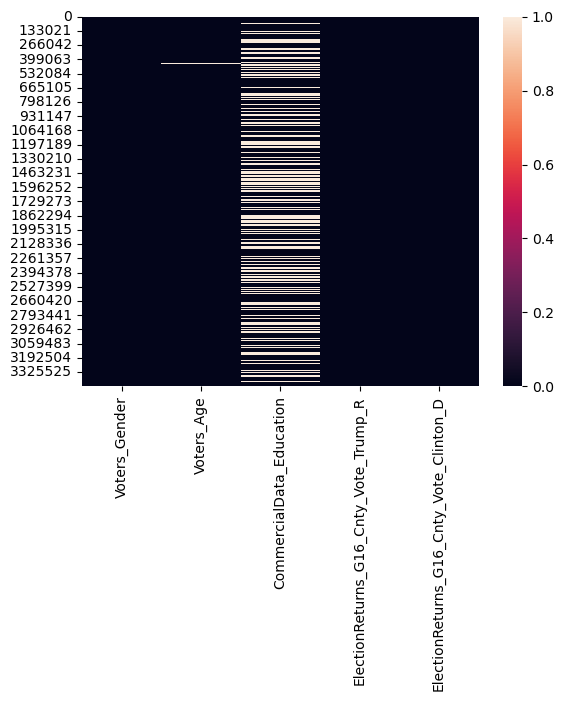

In [10]:
na = df1.select('Voters_Gender','Voters_Age',\
                   'CommercialData_Education','ElectionReturns_G16_Cnty_Vote_Trump_R','ElectionReturns_G16_Cnty_Vote_Clinton_D')
na_map = na.toPandas()

tf_na = na_map.isnull()

sns.heatmap(data=tf_na)
plt.xticks(rotation = 90, fontsize = 10)
plt.yticks(rotation = 0, fontsize = 10)
plt.show();

Here, we wanted to see how many null values were in each column. We see that only CommercialData_Education has missing values.

#### Furthermore, we want to consider the correlation between the voter's background and voter turnout to find out the true behavior behind the voting patterns for the 'red' states.

In [101]:
states = ['VM2Uniform--FL--2021-05-19'
,'VM2Uniform--GA--2021-04-16'
,'VM2Uniform--MS--2021-03-23'
,'VM2Uniform--SC--2021-04-16'
,'VM2Uniform--TN--2021-03-29'
,'VM2Uniform--TX--2021-06-12']
gcs_path = 'gs://pstat135-voter-file/VM2Uniform/'
numrows = dict()
print('VM2Uniform--AL--2021-02-04')
df = spark.read.parquet("/".join([gcs_path, 'VM2Uniform--AL--2021-02-04']))
df = df.withColumn('State', f.lit('AL'))
print(df.count())

for one_state in states:
    print("%s: " % (one_state), end="")
    # read dataframe for one_state
    tmp = spark.read.parquet("/".join([gcs_path, one_state]))
    numrows[one_state] = tmp.select('Voters_Gender').count()
    tmp = tmp.withColumn('State', f.lit(one_state[12:14]))
    df = df.union(tmp)

    print("%d" % (numrows[one_state]))

VM2Uniform--AL--2021-02-04


3458534
VM2Uniform--FL--2021-05-19: 

14168189
VM2Uniform--GA--2021-04-16: 

7105478
VM2Uniform--MS--2021-03-23: 

1983032
VM2Uniform--SC--2021-04-16: 

3318276
VM2Uniform--TN--2021-03-29: 

4076696
VM2Uniform--TX--2021-06-12: 

15983112


In [12]:
#df = spark.read.parquet("/".join([gcs_path, 'VM2Uniform--AL--2021-02-04']))
#df = df.withColumn('State', f.lit('AL'))
#print(df.count())

3458534


In [4]:
#df.cache()

In [27]:
#df.printSchema()

### Logistic Regression

In [131]:
new_df = df.select('State','County','Voters_Active', 'Voters_Gender', 'Voters_Age', \
                   "EthnicGroups_EthnicGroup1Desc", "Parties_Description", \
                   "CommercialData_EstimatedHHIncome",  "CommercialData_Education", \
                   'ElectionReturns_G16_Cnty_Vote_Trump_R','ElectionReturns_G16_Cnty_Vote_Clinton_D').dropna()

In [132]:
#new_df.select('CommercialData_EstimatedHHIncome').distinct().show()

+--------------------------------+
|CommercialData_EstimatedHHIncome|
+--------------------------------+
|                  $175000-199999|
|                        $250000+|
|                     $1000-14999|
|                  $100000-124999|
|                    $75000-99999|
|                  $125000-149999|
|                    $25000-34999|
|                  $200000-249999|
|                    $50000-74999|
|                  $150000-174999|
|                    $35000-49999|
|                    $15000-24999|
+--------------------------------+



In [133]:
new_df = new_df.withColumn("ElectionReturns_G16_Cnty_Vote_Trump_R",new_df.ElectionReturns_G16_Cnty_Vote_Trump_R.cast(IntegerType()))

new_df= new_df.withColumn("ElectionReturns_G16_Cnty_Vote_Clinton_D",new_df.ElectionReturns_G16_Cnty_Vote_Clinton_D.cast(IntegerType()))

new_df = new_df.withColumn('VoteRepub', new_df['ElectionReturns_G16_Cnty_Vote_Trump_R'] > new_df['ElectionReturns_G16_Cnty_Vote_Clinton_D'])


new_df.printSchema()

#new_df = new_df.withColumn("County_Swing", f.when(f.col("VoteRepub") == True, "Republican").otherwise("Democrat")) #The column County_Swing has some problems.

root
 |-- State: string (nullable = false)
 |-- County: string (nullable = true)
 |-- Voters_Active: string (nullable = true)
 |-- Voters_Gender: string (nullable = true)
 |-- Voters_Age: string (nullable = true)
 |-- EthnicGroups_EthnicGroup1Desc: string (nullable = true)
 |-- Parties_Description: string (nullable = true)
 |-- CommercialData_EstimatedHHIncome: string (nullable = true)
 |-- CommercialData_Education: string (nullable = true)
 |-- ElectionReturns_G16_Cnty_Vote_Trump_R: integer (nullable = true)
 |-- ElectionReturns_G16_Cnty_Vote_Clinton_D: integer (nullable = true)
 |-- VoteRepub: boolean (nullable = true)



In [134]:
new_df = new_df.withColumn('Poor', new_df.CommercialData_EstimatedHHIncome.isin(\
        '$1000-14999', '$15000-24999', '$25000-34999').astype('double'))
new_df = new_df.withColumn('Wealthy', new_df.CommercialData_EstimatedHHIncome.isin(\
        '$125000-149999', '$150000-174999', '$175000-199999', '$2000000-249999', '$250000+').astype('double'))

In [135]:
new_df = new_df.withColumn('Age', new_df.Voters_Age.astype('double'))
new_df = new_df.withColumn('Gender', (new_df.Voters_Gender == 'M').astype('double'))
new_df = new_df.withColumn('VoteRepub', (new_df.VoteRepub).astype('int'))
new_df = new_df.withColumn('HasDegree', (new_df.CommercialData_Education.contains('Degree')).astype('double'))
new_df = new_df.withColumn('European', (new_df.EthnicGroups_EthnicGroup1Desc.contains('Euro')).astype('double'))
new_df = new_df.withColumn('African', (new_df.EthnicGroups_EthnicGroup1Desc.contains('Africa')).astype('double'))
new_df = new_df.withColumn('Asian', (new_df.EthnicGroups_EthnicGroup1Desc.contains('Asia')).astype('double'))
new_df = new_df.withColumn('Latino', (new_df.EthnicGroups_EthnicGroup1Desc.contains('Hisp')).astype('double'))
new_df = new_df.withColumn('Other', (new_df.EthnicGroups_EthnicGroup1Desc.contains('Other')).astype('double'))
new_df = new_df.drop('Voters_Age', 'Voters_Gender')
#new_df.show()

In [136]:
new_df = new_df.select('State', 'County', 'Age', 'Gender', 'HasDegree', 'European', 'African', 'Asian', \
                       'Latino', 'Other', 'Poor', 'Wealthy', 'VoteRepub')
new_df.show()

+-----+---------+----+------+---------+--------+-------+-----+------+-----+----+-------+---------+
|State|   County| Age|Gender|HasDegree|European|African|Asian|Latino|Other|Poor|Wealthy|VoteRepub|
+-----+---------+----+------+---------+--------+-------+-----+------+-----+----+-------+---------+
|   AL|COVINGTON|24.0|   0.0|      0.0|     0.0|    1.0|  0.0|   0.0|  0.0| 0.0|    0.0|        1|
|   AL|COVINGTON|23.0|   0.0|      0.0|     0.0|    1.0|  0.0|   0.0|  0.0| 0.0|    0.0|        1|
|   AL|COVINGTON|84.0|   0.0|      1.0|     1.0|    0.0|  0.0|   0.0|  0.0| 0.0|    0.0|        1|
|   AL|COVINGTON|78.0|   1.0|      0.0|     0.0|    1.0|  0.0|   0.0|  0.0| 1.0|    0.0|        1|
|   AL|COVINGTON|63.0|   0.0|      1.0|     0.0|    1.0|  0.0|   0.0|  0.0| 1.0|    0.0|        1|
|   AL|COVINGTON|67.0|   1.0|      0.0|     1.0|    0.0|  0.0|   0.0|  0.0| 0.0|    0.0|        1|
|   AL|COVINGTON|66.0|   0.0|      0.0|     1.0|    0.0|  0.0|   0.0|  0.0| 1.0|    0.0|        1|
|   AL|COV

In [137]:
new_df.createOrReplaceTempView('new_df')

In [140]:
new_df = spark.sql('SELECT State, County, \
                    ROUND(AVG(Age),4) as Age, \
                    ROUND(AVG(Gender),4) as Gender, \
                    ROUND(AVG(HasDegree),4) as HasDegree, \
                    COUNT(*) as Population, \
                    ROUND(AVG(European), 4) as European, \
                    ROUND(AVG(African), 4) as African, \
                    ROUND(AVG(Asian), 4) as Asian, \
                    ROUND(AVG(Latino), 4) as Latino, \
                    ROUND(AVG(Other), 4) as Other, \
                    ROUND(AVG(Poor), 4) as Poor, \
                    ROUND(AVG(Wealthy), 4) as Wealthy, \
                    ROUND(AVG(VoteRepub),4) as VoteRepub \
                    FROM new_df GROUP BY State, County')

In [141]:
new_df.show(50)

+-----+----------+-------+------+---------+----------+--------+-------+------+------+------+------+-------+---------+
|State|    County|    Age|Gender|HasDegree|Population|European|African| Asian|Latino| Other|  Poor|Wealthy|VoteRepub|
+-----+----------+-------+------+---------+----------+--------+-------+------+------+------+------+-------+---------+
|   AL|    MONROE| 54.441|  0.44|   0.2604|      8848|  0.5996| 0.3837|0.0028|0.0058|0.0081|0.2639| 0.0677|      1.0|
|   AL|      DALE|55.4523| 0.458|   0.2918|     17381|  0.7571| 0.1988|0.0094|0.0278|0.0068|0.2274| 0.0936|      1.0|
|   AL|     HENRY|56.0364|0.4621|   0.3188|      8150|  0.7242| 0.2556|0.0045|0.0104|0.0053|0.2169| 0.1086|      1.0|
|   AL|LAUDERDALE|55.3264|0.4656|    0.366|     39356|  0.8898| 0.0833|0.0055|0.0135|0.0079| 0.192| 0.1285|      1.0|
|   AL|      HALE|53.6399|0.4171|   0.2564|      6814|  0.4155| 0.5754|0.0025|0.0038|0.0028| 0.281| 0.0566|      0.0|
|   AL|  LAWRENCE|54.7935|0.4696|    0.277|     15048|  

In [142]:
new_df.cache()

DataFrame[State: string, County: string, Age: double, Gender: double, HasDegree: double, Population: bigint, European: double, African: double, Asian: double, Latino: double, Other: double, Poor: double, Wealthy: double, VoteRepub: double]

In [147]:
from pyspark.ml.feature import RFormula

supervised = RFormula(formula="VoteRepub ~ Age + Gender + HasDegree + Population + European + African + Asian + Latino + Poor + Wealthy" )

In [148]:
fittedRF = supervised.fit(new_df)  # fit the transformer
preparedDF = fittedRF.transform(new_df)  # transform
preparedDF.show(5, False)

+-----+-------+-------+------+---------+----------+--------+-------+------+------+------+------+-------+---------+-------------------------------------------------------------------------+-----+
|State|County |Age    |Gender|HasDegree|Population|European|African|Asian |Latino|Other |Poor  |Wealthy|VoteRepub|features                                                                 |label|
+-----+-------+-------+------+---------+----------+--------+-------+------+------+------+------+-------+---------+-------------------------------------------------------------------------+-----+
|AL   |BULLOCK|54.4835|0.3994|0.2584   |3708      |0.2481  |0.7416 |0.0016|0.0049|0.0038|0.3142|0.0704 |0.0      |[54.4835,0.3994,0.2584,3708.0,0.2481,0.7416,0.0016,0.0049,0.3142,0.0704] |0.0  |
|TX   |DONLEY |57.6667|0.4894|0.2439   |1230      |0.9333  |0.0081 |0.0098|0.0463|0.0024|0.2358|0.0545 |1.0      |[57.6667,0.4894,0.2439,1230.0,0.9333,0.0081,0.0098,0.0463,0.2358,0.0545] |1.0  |
|MS   |PIKE   |58.0021|0.

In [149]:
preparedDF.count()

770

In [150]:
train, test = preparedDF.randomSplit([0.8, 0.2], seed = 1729)

In [151]:
test.show(20)

+-----+----------+-------+------+---------+----------+--------+-------+------+------+------+------+-------+---------+--------------------+-----+
|State|    County|    Age|Gender|HasDegree|Population|European|African| Asian|Latino| Other|  Poor|Wealthy|VoteRepub|            features|label|
+-----+----------+-------+------+---------+----------+--------+-------+------+------+------+------+-------+---------+--------------------+-----+
|   MS|      PIKE|58.0021|0.4248|   0.3159|     11214|  0.5218| 0.4614|0.0036|0.0095|0.0037|0.2847| 0.0838|      0.0|[58.0021,0.4248,0...|  0.0|
|   TN|     COCKE|57.2187|  0.46|   0.2668|     13199|  0.9665| 0.0129|0.0047|0.0117|0.0042|0.2646| 0.0559|      1.0|[57.2187,0.46,0.2...|  1.0|
|   TX|  JIM HOGG|53.0221|0.4804|   0.2579|      2036|  0.0678|    0.0|0.0015|0.9288| 0.002|0.2834|  0.054|      0.0|[53.0221,0.4804,0...|  0.0|
|   GA| EFFINGHAM|50.5785| 0.488|   0.2926|     23829|  0.8227| 0.1237|0.0081|0.0348|0.0106|0.1233| 0.1651|      1.0|[50.5785,0.48

In [153]:
from pyspark.ml.classification import LogisticRegression

fittedLR = LogisticRegression().fit(train)

In [154]:
predictions = fittedLR.transform(test)
#.select("label", "prediction",'probability')

In [197]:
prediction_pd = predictions.toPandas()
#pd.set_option('display.max_rows', None)
#prediction_pd.drop(columns = ['features', 'rawPrediction'])

In [203]:
prediction_pd['Rep_Confidence'] = prediction_pd.probability.apply(lambda x: x[0])
prediction_pd.where(prediction_pd['Rep_Confidence'] > 0.2).where(prediction_pd['Rep_Confidence'] < 0.8).dropna()

,State,County,Age,Gender,HasDegree,Population,European,African,Asian,Latino,Other,Poor,Wealthy,VoteRepub,features,label,rawPrediction,probability,prediction,Rep_Confidence
0,MS,PIKE,58.0021,0.4248,0.3159,11214.0,0.5218,0.4614,0.0036,0.0095,0.0037,0.2847,0.0838,0.0,"[58.0021, 0.4248, 0.3159, 11214.0, 0.5218, 0.4...",0.0,"[0.7908550654973632, -0.7908550654973632]","[0.6880149002319591, 0.3119850997680409]",0.0,0.688015
19,FL,PALM BEACH,56.3107,0.4559,0.4857,506056.0,0.6167,0.1474,0.0218,0.1780,0.0360,0.1166,0.2643,0.0,"[56.3107, 0.4559, 0.4857, 506056.0, 0.6167, 0....",0.0,"[-1.3143358151815239, 1.3143358151815239]","[0.21176220981751465, 0.7882377901824853]",1.0,0.211762
71,MS,MARSHALL,58.1967,0.4358,0.2982,10555.0,0.5080,0.4721,0.0030,0.0136,0.0032,0.2605,0.0595,0.0,"[58.1967, 0.4358, 0.2982, 10555.0, 0.508, 0.47...",0.0,"[0.8791711732687557, -0.8791711732687557]","[0.7066504383944047, 0.29334956160559533]",0.0,0.706650
144,TX,TARRANT,51.4277,0.4677,0.4613,671538.0,0.6665,0.0920,0.0424,0.1758,0.0234,0.1038,0.2614,1.0,"[51.4277, 0.4677, 0.4613, 671538.0, 0.6665, 0....",1.0,"[-0.5962190217084953, 0.5962190217084953]","[0.35520919764289516, 0.6447908023571048]",1.0,0.355209


In [156]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator
multi_evaluator = MulticlassClassificationEvaluator()
bin_evaluator = BinaryClassificationEvaluator()
print(multi_evaluator.evaluate(predictions, {multi_evaluator.metricName:"accuracy"}))
print(bin_evaluator.evaluate(predictions, {bin_evaluator.metricName:"areaUnderROC"}))

0.9793103448275862


0.997


The AOC-ROC is 0.9355

In [157]:
summary = fittedLR.summary 

In [158]:
coeff = fittedLR.coefficients
coeff

DenseVector([0.4401, -0.4257, -23.5171, -0.0, 16.0508, -51.1578, -74.1327, -28.1018, -3.7548, -6.4925])

In [159]:
#predictions.Age*coeff[0] + predictions.Gender*coeff[1] + predictions.HasDegree*coeff[2] + predictions.Population*coeff[3] + fittedLR.intercept

In [160]:
print(summary.accuracy, summary.weightedPrecision, summary.weightedRecall)

0.9824 0.9823374428697622 0.9823999999999999


In [161]:
summary.areaUnderROC

0.9977333333333334

Param Grid Tuning